In [1]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AdQt8qjoGXTyXX9xvO19iVwUhV4or0asUoW8ulTew5iW5c_9cD6nnfq6XIM

Successfully saved authorization token.


In [14]:
caliop_footprint_table = ee.FeatureCollection('projects/ee-ruisong/assets/caliop_footprint')
aeolus_footprint_table = ee.FeatureCollection('projects/ee-ruisong/assets/aeolus_footprint')


In [15]:
# Import CAMS aerosol data, and filter data.
aerosol_data = ee.ImageCollection('ECMWF/CAMS/NRT').filter(ee.Filter.date('2020-06-15', '2020-06-19')).select('total_aerosol_optical_depth_at_550nm_surface').filterMetadata('model_initialization_datetime','equals','2020-06-15T00:00:00')
data_size = aerosol_data.size().getInfo()
print('Number of filtered images:', data_size)

def add_Datetime(img):
    
    return img.select(['total_aerosol_optical_depth_at_550nm_surface']).set({'forecasting_time': ee.Date(img.get('model_initialization_datetime')).advance(img.get('model_forecast_hour'), 'hour')});  
      
dataset_aod = aerosol_data.map(add_Datetime)


Number of filtered images: 32


In [16]:
# definte AOI over north Africa
AOI_NorthAfrica = ee.Geometry.Polygon([[-56.68958483569779,1.7740538069405383],[15.029165164302212,1.7740538069405383],[15.029165164302212,38.28566056379576],[-56.68958483569779,38.28566056379576],[-56.68958483569779,1.7740538069405383]]);


In [17]:
# load boundary data (plotting global land boundary)
global_boundary = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017');


In [18]:
# visualise feature collection (boundary)
# Define an empty image to paint features to.
empty = ee.Image().byte();

# Paint country feature edges to the empty image.
boundaryOutline = empty.paint(**{
  'featureCollection': global_boundary,
  'color': 1,
  'width': 1,
});


In [23]:
# add satellite footprint
# stations = [
#   ee.Feature(
#       ee.Geometry.Point(-14, 23.8), {'name': 'obs_1', 'system:time_start': ee.Date('2020-06-15T16:00:00')}),
#   ee.Feature(
#       ee.Geometry.Point(-12, 18.8), {'name': 'obs_2', 'system:time_start': ee.Date('2020-06-17T16:00:00')}),
# ]
# bartStations = ee.FeatureCollection(stations)

# add start:date to caliop footprint

def footprintsetDate(f):
    return f.set({'system:time_start': ee.Date(f.get('Timestamp'))}); 

caliop_footprint_table_date = caliop_footprint_table.map(footprintsetDate)
aeolus_footprint_table_date = aeolus_footprint_table.map(footprintsetDate)

# Map a function over the collection to buffer each feature.
def func_dky_caliop(f):
  return f.buffer(20000, 100); # Note that the errorMargin is set to 100.

def func_dky_aeolus(f):
  return f.buffer(80000, 100);
# buffered = bartStations.map(func_dky)


In [24]:
visArgs = {
  'min': 0.000096,
  'max': 3.582552,
  'palette': [
    "5E4FA2",
    "3288BD",
    "66C2A5",
    "ABE0A4",
    "E6F598",
    "FFFFBF",
    "FEE08B",
    "FDAE61",
    "F46D43",
    "D53E4F",
    "9E0142",
  ]
};


def addImageVisualise(image):
    return image.visualize(**visArgs).set({'forecasting_time': ee.Date(image.get('model_initialization_datetime')).advance(image.get('model_forecast_hour'), 'hour')});  

def addBoundary(image):
    return image.blend(boundaryOutline.visualize(**{'palette': '000000'}))

time_window = 1.5


def addFootPrint(image):
    
    buffered_caliop = caliop_footprint_table_date.map(func_dky_caliop)
    buffered_caliop_filtered = buffered_caliop.filter(ee.Filter.date(ee.Date(image.get('forecasting_time')).advance(-1.5, 'hour'), ee.Date(image.get('forecasting_time')).advance(1.5, 'hour')));
    
    buffered_aeolus = aeolus_footprint_table_date.map(func_dky_aeolus)
    buffered_aeolus_filtered = buffered_aeolus.filter(ee.Filter.date(ee.Date(image.get('forecasting_time')).advance(-1.5, 'hour'), ee.Date(image.get('forecasting_time')).advance(1.5, 'hour')));
 
    empty_caliop = ee.Image().byte();
    
    boundaryFootPrint_caliop = empty_caliop.paint(**{
      'featureCollection': buffered_caliop_filtered,
      'color': 1,
      'width': 3,
        });
    
    empty_aeolus = ee.Image().byte();
    boundaryFootPrint_aeolus = empty_aeolus.paint(**{
      'featureCollection': buffered_aeolus_filtered,
      'color': 1,
      'width': 3,
        });
    
    return image.blend(boundaryFootPrint_caliop.visualize(**{'palette': 'FF0000'})).blend(boundaryFootPrint_aeolus.visualize(**{'palette': '0040FF'}))

aeosolVisualise = dataset_aod.map(addImageVisualise)
aeosolVisualiseBoudary = aeosolVisualise.map(addBoundary)
aeosolVisualiseFootPrint = aeosolVisualiseBoudary.map(addFootPrint)

videoArgs = {
  'dimensions': 1000,
  'region': AOI_NorthAfrica,
  'framesPerSecond': 1,
  'crs': 'EPSG:3857'
};

# display video in a link
# print(aeosolVisualiseFootPrint.getVideoThumbURL(videoArgs));

import geemap
import os
saved_gif = os.path.join(os.path.expanduser('~'), 'Downloads/sahara_dust_2020.gif')
geemap.download_ee_video(aeosolVisualiseFootPrint, videoArgs, saved_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/rs/Downloads/sahara_dust_2020.gif


In [13]:
from datetime import datetime, timedelta
import numpy as np

initialization_datetime = aerosol_data.reduceColumns(ee.Reducer.toList(), ["model_initialization_datetime"]).get('list').getInfo()
model_forecast_hour = aerosol_data.reduceColumns(ee.Reducer.toList(), ["model_forecast_hour"]).get('list').getInfo()
model_forecast_datetime = []

for i in range(len(initialization_datetime)):
    
    initialization_datetime_i = datetime.strptime(initialization_datetime[i], '%Y-%m-%dT%H:%M:%S')
    model_forecast_datetime_i = initialization_datetime_i + timedelta(hours=int(model_forecast_hour[i]))
    model_forecast_datetime.append(model_forecast_datetime_i)

    
out_gif = os.path.join(os.path.expanduser('~'), 'Downloads/sahara_dust_2020_saved.gif')  
geemap.add_text_to_gif(
    saved_gif,
    out_gif,
    xy=('3%', '2%'),
    text_sequence=model_forecast_datetime,
    font_size=30,
    font_color='#ffffff',
)
# os.system('rm -rf %s'%saved_gif)


In [14]:
# test image collection reducer
print('start reducer...')
def CollectionReducer(image):
    
    buffered = caliop_footprint_table_date.map(func_dky)
    buffered_filtered = buffered.filter(ee.Filter.date(ee.Date(image.get('forecasting_time')).advance(-1.5, 'hour'), ee.Date(image.get('forecasting_time')).advance(1.5, 'hour')));
    
    return image.reduceRegions(**{'collection': buffered_filtered,'reducer': ee.Reducer.mean(),'scale': 30})

aod_mean_flatten = dataset_aod.map(CollectionReducer).flatten()

CAMS_aod_mean_values = aod_mean_flatten.reduceColumns(ee.Reducer.toList(), ["mean"]).get('list').getInfo()
CALIOP_aod_mean_values = aod_mean_flatten.reduceColumns(ee.Reducer.toList(), ["AOD"]).get('list').getInfo()

CAMS_aod_mean_values_numpy_list = [i for i in CAMS_aod_mean_values]
CALIOP_aod_mean_values_numpy_list = [i for i in CALIOP_aod_mean_values]



start reducer...


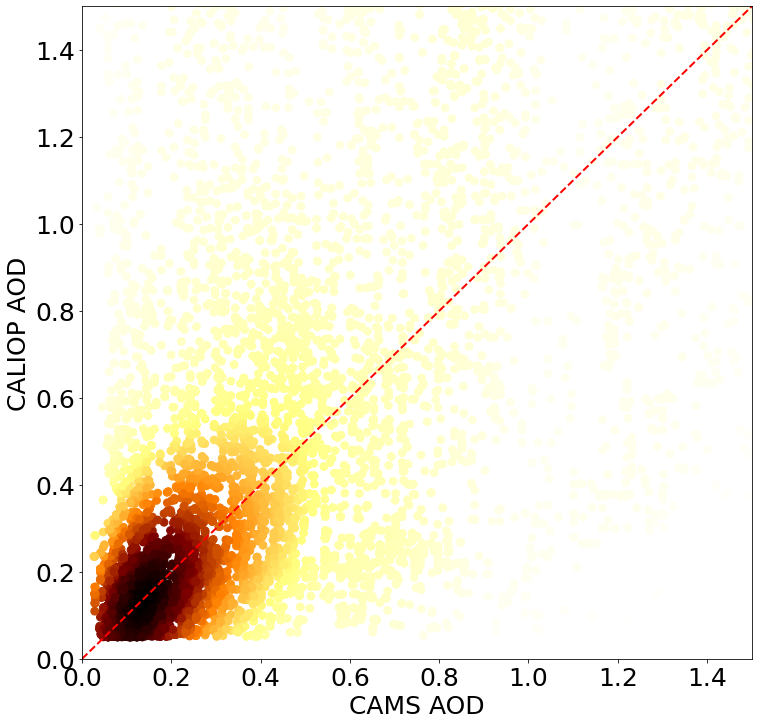

In [17]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

x = CAMS_aod_mean_values_numpy_list
y = CALIOP_aod_mean_values_numpy_list
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

x1 = np.linspace(0, 5 , 100)
y1 = np.linspace(0, 5 , 100)

fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(CAMS_aod_mean_values_numpy_list, CALIOP_aod_mean_values_numpy_list, c=z, s=60, cmap='afmhot_r')
plt.plot(x1, y1, 'r--', lw=2, label='1:1')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

plt.xlim([0., 1.5])
plt.ylim([0., 1.5])

plt.xlabel('CAMS AOD', fontsize=25)
plt.ylabel('CALIOP AOD', fontsize=25)

plt.show()

In [24]:
import geemap

Map = geemap.Map(center=[40,-100], zoom=4)

# Add Earth Engine dataset
Map.setCenter(-122.4, 37.7, 11)

bart_stations = ee.FeatureCollection('GOOGLE/EE/DEMOS/bart-locations')
print(bart_stations.get('constantValue'))
buffered = bart_stations.map(lambda f: f.buffer(2000))
unioned = buffered.union()

Map.addLayer(unioned, {'color': '800080'}, "BART stations")
Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.

download_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
html_file = os.path.join(download_dir, 'my_map.html')

Map.to_html(filename=html_file, title='My Map', width='100%', height='880px')

None


ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_1_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "Image.reduceRegions",
              "arguments": {
                "collection": {
                  "functionInvocationValue": {
                    "functionName": "Collection.map",
                    "arguments": {
                      "baseAlgorithm": {
                        "functionDefinitionValue": {
                          "argumentNames": [
                            "_MAPPING_VAR_0_0"
                          ],
                          "body": {
                            "functionInvocationValue": {
                              "functionName": "Feature.buffer",
                              "arguments": {
                            

In [64]:
# example of using point buffer
import geemap

Map = geemap.Map(center=[23,-13], zoom=4)

stations = [
  ee.Feature(
      ee.Geometry.Point(-14, 23.8), {'name': '16th St. Mission (16TH)'}),
  ee.Feature(
      ee.Geometry.Point(-12, 18.8), {'name': '24th St. Mission (24TH)'})
]
bartStations = ee.FeatureCollection(stations)

# Map a function over the collection to buffer each feature.
def func_dky(f):
  return f.buffer(200000, 100); # Note that the errorMargin is set to 100.

buffered = bartStations.map(func_dky)
Map.addLayer(buffered, {'color': '800080'})

download_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
html_file = os.path.join(download_dir, 'my_map.html')

Map.to_html(filename=html_file, title='My Map', width='100%', height='880px')